Recurent version of "sinus-full" to predict values outside of range as well


In [1]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)

C:\Users\kicjo\Desktop\my-anns\sinus\sinus_recurrent_time_series


In [2]:
tf.VERSION

'1.14.0'

In [3]:
import platform
print(platform.python_version())

3.7.3


In [4]:
t_min, t_max = -5, 5
section_start = (t_max + t_min) / 2
resolution = 0.1
n_steps = 20

def time_series(t):
    return np.sin(t)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [6]:
xxs, yys = next_batch(10,20)
xxs[0]

array([[-0.71281925],
       [-0.63924018],
       [-0.55927403],
       [-0.47371979],
       [-0.38343231],
       [-0.2893137 ],
       [-0.19230436],
       [-0.09337358],
       [ 0.00649015],
       [ 0.10628904],
       [ 0.20502593],
       [ 0.30171426],
       [ 0.39538797],
       [ 0.48511109],
       [ 0.56998714],
       [ 0.64916806],
       [ 0.72186272],
       [ 0.78734476],
       [ 0.84495991],
       [ 0.8941325 ]])

Text(0.5, 0, 'Time')

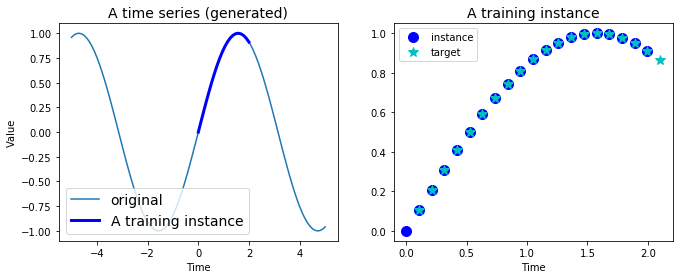

In [5]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

t_instance = np.linspace(start = section_start, stop = section_start + resolution * (n_steps + 1),num = n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"original")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
#plt.axis([-10, 10, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "c*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


In [6]:
n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])


In [7]:
cell =  tf.keras.layers.SimpleRNNCell(units=n_neurons, activation=tf.nn.relu)                        

W0805 14:36:53.224760 13828 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [29]:
rnn_outputs, rnn_states  = tf.keras.layers.RNN(cell,dtype=tf.float32, name="hidden1", return_state=True, return_sequences=True)(X)
print(rnn_outputs.get_shape())
print(rnn_states.get_shape())

(?, 20, 100)
(?, 100)


"rnn_outputs" without "return_sequences" is of (m,100) shape (batch_size, output_size). With "return_sequences" it is of (batch_size, timesteps, output_size) and because we are dealing with time series we want the time steps as well (they are next steps in our sin(x) function - i think :))

In [21]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons], name='reshape1')
print(stacked_rnn_outputs.get_shape())


(?, 100)


we are reshaping twice because we want to put the series output into single dense layer so we get (m, 1) shape. it is not segregated with regard to their time stamps (series) so we have to "un-reshape" it so we have (m, 20,1) tensor, where 20 is a series for each input. So 19th element from outputs is equal to 20th element in inputs. Last element in output is the one we wanted to predict.

In [26]:
stacked_outputs = tf.keras.layers.Dense(n_outputs,name="hidden2")(stacked_rnn_outputs)
print(stacked_outputs.get_shape())


(?, 1)


In [23]:
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs], name='reshape2')
print(outputs.get_shape())

(?, 20, 1)


In [24]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
n_iterations = 1500
batch_size = 50
save_path =os.path.join(dir_path,"model","recurrent_sinus_model")

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    saver.save(sess, save_path)

0 	MSE: 0.24545139
100 	MSE: 0.0024254364
200 	MSE: 0.00034177402
300 	MSE: 0.0006718333
400 	MSE: 0.00026167225
500 	MSE: 0.00067107164
600 	MSE: 0.00031190444
700 	MSE: 0.00045202477
800 	MSE: 0.00023139367
900 	MSE: 0.00032528007
1000 	MSE: 0.00018489936
1100 	MSE: 0.00022460258
1200 	MSE: 0.00022434423
1300 	MSE: 0.00024490056
1400 	MSE: 0.00021996237


In [ ]:
with tf.Session() as sess:                      
    saver.restore(sess, save_path)  

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [ ]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [ ]:
with tf.Session() as sess:                      
    saver.restore(sess, save_path)  

    X_new = time_series(np.array(t.reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

In [ ]:
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"original",linewidth=5,c='r')
plt.plot(t[:-1], time_series(t[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)

plt.xlabel("Time")
plt.ylabel("Value")